# Landslide movement prediction — LSTM / Bi-LSTM / CNN-LSTM
**Goal:** To predict future landlside movements(*t+1*) using current (*t*) and past (*t-1, t-2, t-3*) data.




# README — Run-order & Quick Troubleshooting

**Purpose:** quick-run checklist and fixes for the landslide prediction notebook.


## Recommended run order (fresh kernel)
1. **Cell 0 — Install dependencies** (run once in a fresh environment).  
2. **Module 1 — Imports & CONFIG** (ensure `CONFIG` is defined).  
3. **Module 2 — DataPre-Processing**
4. **Module 2.1 — DataEngine** (class definition).  
5. **Module 2.2 — DataAnalyzer** (EDA helpers).  
6. **Module 2.3 — Load data, EDA, scaling, holdout split** (creates `X_train_full`, `X_holdout`, `y_train_full`, `y_holdout`).  
7. **Module 3 — Model builders** (LSTM, CNN-LSTM, BiLSTM).  
8. **Module 4 — Evaluator** (thresholding and metrics).
9. **Module 5 - Plotting and Saving model**: `_plot_history`, `_save_metrics_and_model_files` (use the fixed saver included here).  
10. **Module 6 : Save Model & Metrics Utility**
11. **Module 7 — Function to run single model** (training/evaluation pipeline).  
12. **Modules (7.1 - 7.3) - Per-model run cells** (LSTM, CNN-LSTM, Bi-LSTM) — run each separately.  
13. **Module 8 - Final comparison** (collect metrics and plot train/test graphs).


## Troubleshooting tips
- If you see `KeyError: 'OUTPUT_DIR'`, run the CONFIG cell again or run the `ensure_output_dir` cell included below.
- If the kernel restarts, re-run cells from the top in the order above. Use the pre-flight check to confirm readiness.
- To avoid leaking test data, thresholds are tuned on **training predictions only** and then applied to the test set. Keep this workflow when modifying the code.


# Cell 0: Install Dependencies

This cell installs all the required Python packages for the notebook:

- TensorFlow  
- NumPy  
- Pandas  
- Scikit-Learn  
- Matplotlib  
- Seaborn  
- tqdm  
- h5py  









In [1]:
# @title Cell 0 — Install Dependencies
# -------------------------------------------------------------
# Install Dependencies
# -------------------------------------------------------------
# Run this only once when using a fresh Colab runtime or new environment.
# After installation, the output is cleared automatically.

# Install required libraries
!pip install --upgrade pip
!pip install numpy pandas scikit-learn matplotlib seaborn tensorflow tqdm h5py

# Clear output to keep notebook tidy
from IPython.display import clear_output
clear_output(wait=True)

print("✔ Dependencies installed")


✔ Dependencies installed


# Module 1 — Imports & Configuration

This module centralizes all imports and experiment configuration.  
**run it first**.
It sets seeds for reproducibility and defines the global `CONFIG` and `BASE_FEATURES` used by downstream modules.



In [2]:
# @title Imports
# Module 1 — Imports

# Standard library
import os, random
import json
from datetime import datetime

# Data / numeric
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score
)

# Reproducibility: set seeds for numpy and TF to reduce run-to-run variance.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# @title Configuration
# Central configuration dictionary: change experiment settings here.
CONFIG = {
    'FILE_PATH': 'sample.csv',   # path to dataset CSV
    'TARGET_COL': 'Movements_t+1',       # target column name in CSV
    'RANDOM_SEED': RANDOM_SEED,
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'TEST_SIZE': 0.20,                   # fraction to hold out as unseen test set
    'N_CLASSES': 3,                      # number of movement classes (0,1,2)
    'SUFFIXES': ['_t-3', '_t-2', '_t-1', ''],  # used to assemble time-lagged column names

# required by run_single_model(), outputs saved here
    'OUTPUT_DIR': 'outputs'
    }

# Raw base features list
BASE_FEATURES = [
    'Tem', 'Hum', 'Pressure', 'Rain', 'Light',
    'Ax', 'Ay', 'Az', 'Wx', 'Wy', 'Wz',
    'Moisture', 'Movements'
]

## **Module 2: Data Pre-processing**

# Module 2.1 — DataEngine

- Load CSV and drops rows with empty cells
- Drop 'Date' column if present
- Generate time-ordered column names for the lagged features
- Provide `prepare_X_y()` and `reshape_for_lstm()`




In [4]:
# @title DataEngine
# Module 2 — DataEngine

class DataEngine:
    """
    Handles data loading and reshaping.
    Methods:
      - _generate_column_names(): construct ordered columns (t-3 ... t)
      - load_data(): read CSV and basic cleaning
      - prepare_X_y(): extract X (flattened) and encoded y
      - reshape_for_lstm(): reshape flattened X -> (N, time_steps, features)
    """
    def __init__(self, config):
        self.config = config
        # Precompute the ordered columns used throughout the pipeline
        self.ordered_cols = self._generate_column_names()

    def _generate_column_names(self):
        # Build feature names in exact sequential order:
        # [Tem_t-3, Hum_t-3, ... , Movements_t-3, Tem_t-2, ... , Movements_t]
        cols = []
        for suffix in self.config['SUFFIXES']:
            for feature in BASE_FEATURES:
                cols.append(f"{feature}{suffix}" if suffix else feature)
        return cols

    def load_data(self):
        # Read CSV, remove rows with missing values, drop Date if present.
        print(f"[DataEngine] Loading file: {self.config['FILE_PATH']}")
        df = pd.read_csv(self.config['FILE_PATH']).dropna()
        if 'Date' in df.columns:
            df = df.drop(columns=['Date'])
        return df

    def prepare_X_y(self, df):
        # Extract features in the canonical order and encode the target labels to integers.
        X = df[self.ordered_cols].values  # shape (N, time_steps * num_features)
        le = LabelEncoder()
        y = le.fit_transform(df[self.config['TARGET_COL']].values)  # e.g., [0,1,2]
        return X, y

    def reshape_for_lstm(self, X_flat):
        # Transform (N, time_steps * features) -> (N, time_steps, features) for Keras LSTM
        num_samples = X_flat.shape[0]
        time_steps = len(self.config['SUFFIXES'])
        num_features = len(BASE_FEATURES)
        return X_flat.reshape(num_samples, time_steps, num_features)

# Instantiate engine for immediate use in the notebook
engine = DataEngine(CONFIG)
print("DataEngine ready — ordered columns sample:", engine.ordered_cols[:6], "...")


DataEngine ready — ordered columns sample: ['Tem_t-3', 'Hum_t-3', 'Pressure_t-3', 'Rain_t-3', 'Light_t-3', 'Ax_t-3'] ...


# Module 2.2 — DataAnalyzer
This module contains Exploratory Data Analysis (EDA) helpers. The main function produces a correlation heatmap for the top-N features which are highly correlated with the target (*Movements t+1*).
Use this before modeling to inspect feature relationships.


In [5]:
# @title 2.2 DataAnalyzer
# Module 2.2 — DataAnalyzer

class DataAnalyzer:
    """
    EDA utilities. Add more helper functions here if needed (histograms, class imbalance plots).
    """
    @staticmethod
    def plot_correlation_matrix(df, target_col, top_n=15, annotate=True):
        """
        Plot heatmap of top_n features most correlated with the target.
        - df: full dataframe with flattened time-lagged columns
        - target_col: name of target column in the df
        - top_n: number of top correlated features to show (including target)
        - annotate: if True, show correlation values in cells
        """
        print("[DataAnalyzer] Computing correlations...")
        corr = df.corr()
        if target_col not in corr.columns:
            raise ValueError(f"Target column '{target_col}' not in dataframe.")
        # Sort by absolute correlation with the target
        target_corr = corr[target_col].abs().sort_values(ascending=False)
        top_features = target_corr.index[:top_n].tolist()
        corr_top = df[top_features].corr()
        plt.figure(figsize=(12,10))
        sns.heatmap(corr_top, annot=annotate, fmt=".2f", cmap='coolwarm', linewidths=0.4)
        plt.title(f"Correlation Matrix (Top {top_n} features w.r.t {target_col})")
        plt.tight_layout()
        plt.show()

# Quick example usage:
# df = engine.load_data()
# DataAnalyzer.plot_correlation_matrix(df, CONFIG['TARGET_COL'], top_n=20)


# Module 2.3: Dataloader & Splitter

Load data → EDA → Scaling → Holdout split

**Purpose:**  
Load the CSV using `DataEngine`, run a quick exploratory check (shape and target distribution), show the correlation heatmap (top-15 features), then prepare `X, y` and split into `X_train_full` and `X_holdout`. Finally, standard-scale the feature matrices.

**What to expect after running:**  
- Console printout with data shape and class balance.  
- Correlation heatmap (top 15 features vs target).  
- `X_train_full`, `y_train_full`, `X_holdout`, `y_holdout` prepared and scaled ready for modeling.  
- Final shapes of train and holdout matrices.

**Run order:** This cell must run **after** Modules 1–3 (imports/config, DataEngine, DataAnalyzer).


[DataEngine] Loading file: sample.csv
Data shape: (20044, 53)
Target distribution:
 Movements_t+1
0    19220
1      613
2      211
Name: count, dtype: int64
[DataAnalyzer] Computing correlations...


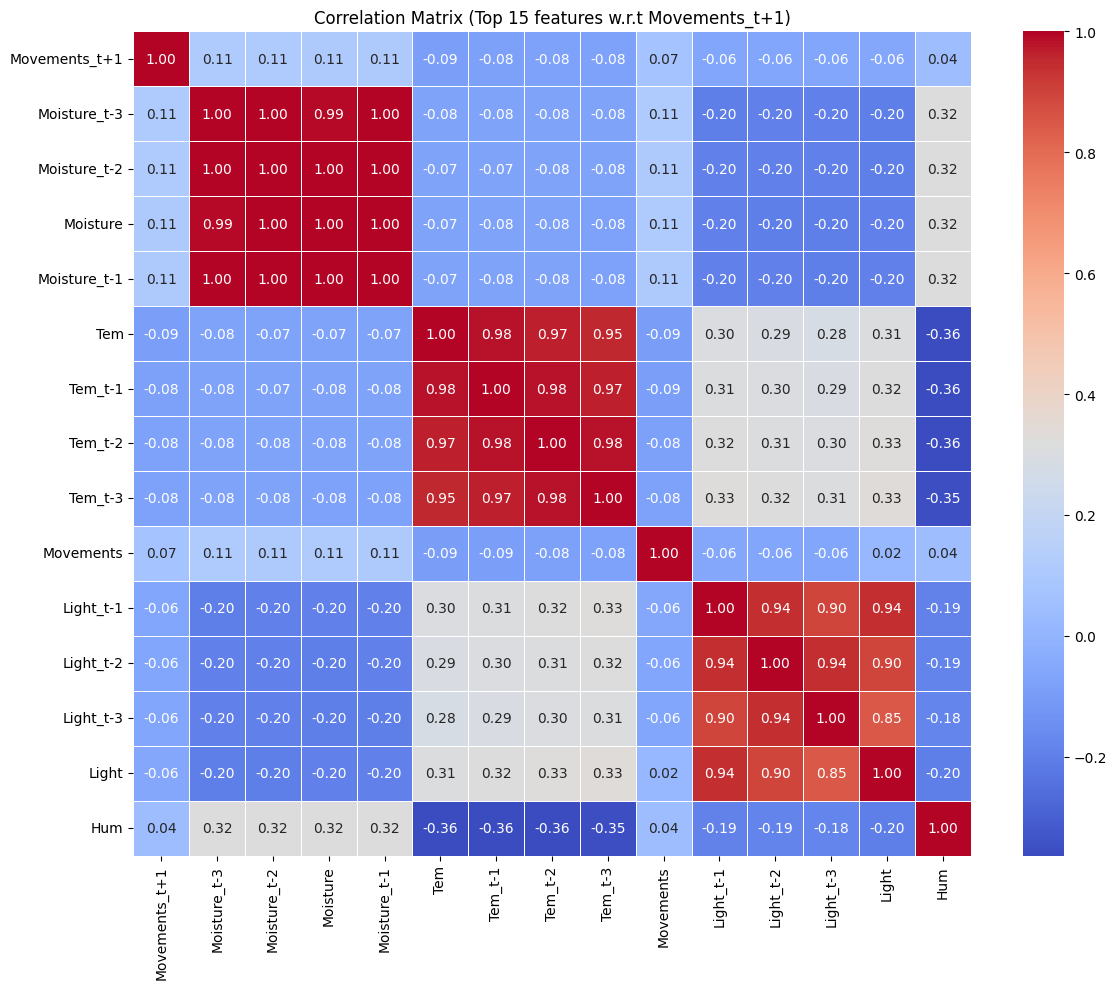

Prepared data. Train shape: (16035, 52) Holdout (Test) shape: (4009, 52)


In [6]:
# @title 2.3: Data → EDA → Scaling → Holdout split → Co-relation analysis
# -------------------------
# Cell: Load data, EDA, scaling and holdout split
# -------------------------

# Instantiate DataEngine which knows ordered column names and helpers
engine = DataEngine(CONFIG)                 # uses CONFIG

# Load dataset into a DataFrame; DataEngine.load_data drops NA and 'Date' if present
df = engine.load_data()                     # returns pandas DataFrame

# Quick EDA: print basic shape and class balance for immediate visibility
print("Data shape:", df.shape)              # number of rows and columns
print("Target distribution:\n", df[CONFIG['TARGET_COL']].value_counts())  # class counts

# Use DataAnalyzer to visualize the top correlated features with target
analyzer = DataAnalyzer()                   # DataAnalyzer defined in Module 3
# Plot correlation heatmap of top 15 features correlated with the target (no annotations to avoid clutter)
analyzer.plot_correlation_matrix(df, CONFIG['TARGET_COL'], top_n=15, annotate=True)

# Prepare feature matrix X and target y using the DataEngine ordering
# X: flattened shape (N, time_steps * num_features), y: encoded integer labels
X, y = engine.prepare_X_y(df)

# Create a held-out test set (unseen during training) using stratified split to preserve class balance
# X_train_full, y_train_full are used for model training; X_holdout, y_holdout are reserved for final evaluation
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y,
    test_size=CONFIG['TEST_SIZE'],      # fraction to hold out (from configuration)
    stratify=y,                         # keep class distribution same in both splits
    random_state=CONFIG['RANDOM_SEED']  # reproducible split
)

# Scale features with StandardScaler (fit on training, transform both train and holdout)
# Important: scaler is fit only on training data to avoid information leak from holdout.
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)   # compute mean/std on training set and scale
X_holdout = scaler.transform(X_holdout)             # use same transformation on holdout

# Final check: print shapes to confirm everything is ready for modeling
print("Prepared data. Train shape:", X_train_full.shape, "Holdout (Test) shape:", X_holdout.shape)


# **Module 3: Building DL Models**

# Module 3.1 : LSTM Model Builder

This module defines the baseline **Simple LSTM** architecture used for classification.  
It converts the reshaped 3D input `(batch, time_steps, features)` into movement-class predictions.

**Architecture summary:**
1. **Input Layer** — expects `(4 time steps × 13 features)`  
2. **LSTM(64)** — learns temporal dependencies across 4 timesteps  
3. **Dropout(0.4)** — regularization to reduce overfitting  
4. **Dense(32, ReLU)** — non-linear transformation  
5. **Dense(num_classes, Softmax)** — outputs class probabilities for {0, 1, 2}  

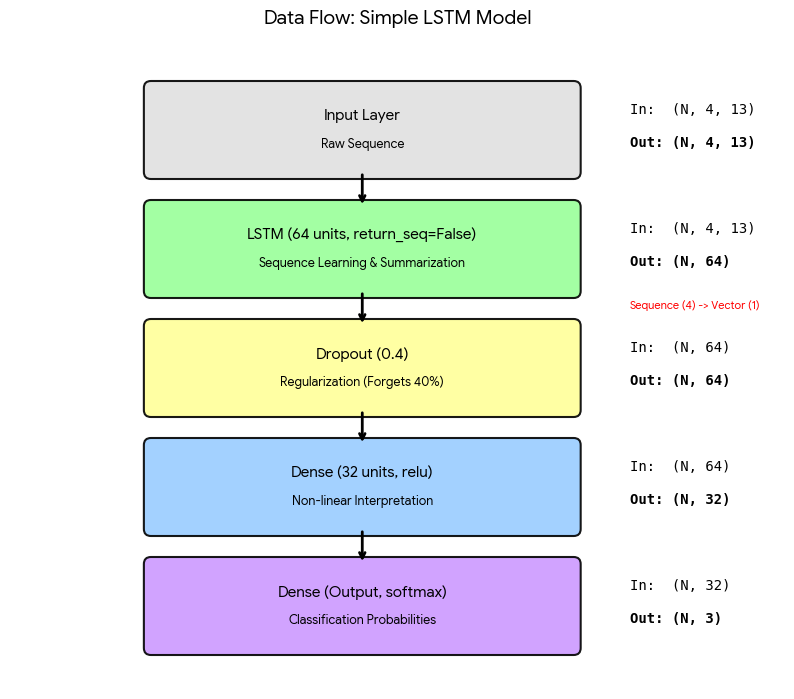

**Compilation:**  
- Optimizer → Adam  
- Loss → sparse categorical cross-entropy  
- Metrics → Accuracy  

You can call this function in your training cell as:

```python
model = build_lstm_module(input_shape, CONFIG['N_CLASSES'])



In [7]:
# @title LSTM Architecture


# -----------------------------------------
# Module: LSTM Model Builder
# -----------------------------------------

def build_lstm_module(input_shape, num_classes):
    """
    Build and compile the Simple LSTM model.

    Parameters
    ----------
    input_shape : tuple
        Shape of the input to the LSTM: (time_steps, num_features).
        For this project, expected shape is (4, 13).
    num_classes : int
        Number of output classes (default = 3).

    Returns
    -------
    model : tf.keras.Model
        A compiled Keras LSTM model ready for training.
    """


    model = Sequential(name="Simple_LSTM")

    # ---- Input Layer ----
    # Accepts 3D tensor shaped (batch, time_steps, features).
    model.add(Input(shape=input_shape))

    # ---- LSTM Layer ----
    # 64 units are enough to capture temporal dependencies across 4 time steps.
    # return_sequences=False → only the final hidden state is fed to next layer.
    model.add(LSTM(64, return_sequences=False))

    # ---- Dropout ----
    # 40% dropout reduces overfitting by randomly zeroing some neuron activations.
    model.add(Dropout(0.4))

    # ---- Dense Hidden Layer ----
    # Intermediate representation of size 32 to add non-linearity.
    model.add(Dense(32, activation='relu'))

    # ---- Output Layer ----
    # Softmax converts logits to class probabilities (size = num_classes).
    model.add(Dense(num_classes, activation='softmax'))

    # ---- Compile Model ----
    # sparse_categorical_crossentropy is used because y labels are integers (0,1,2).
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Example usage (in later training cell)
# input_shape = (4, 13)
# model = build_lstm_module(input_shape, 3)
# model.summary()


# Module 3.2 : CNN–LSTM Model Builder

This module defines the **CNN-LSTM hybrid architecture**, which combines:

1. **1D Convolution Layer**  
   Extracts local temporal patterns and smooths sensor noise, making the input sequence more structured before entering the LSTM.

2. **MaxPooling1D**  
   Maintains key temporal features while reducing minor fluctuations.

3. **Dropout**  
   Helps prevent overfitting by randomly deactivating a fraction of activations.

4. **LSTM Layer (64 units)**  
   Learns temporal dependencies across the 4-timestep sequence window.

5. **Dense Layers**  
   Add capacity for non-linear representation before the softmax classifier.

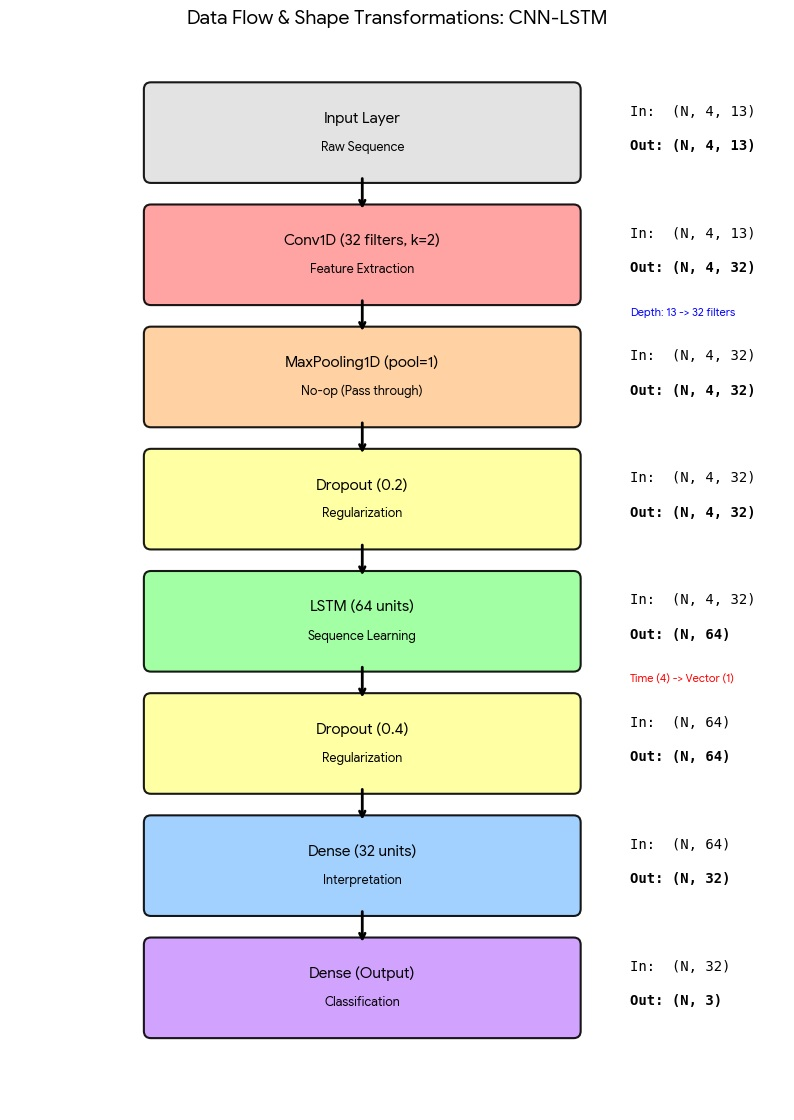

**Why CNN-LSTM?**  
Sensor-based landslide data often contain micro-spikes, local trends, and short bursts.  
The CNN layer acts as a **feature extractor**, making the LSTM’s job easier and often improving stability on noisy real-world sequences.

**Compilation**  
- Optimizer: Adam  
- Loss: Sparse categorical cross-entropy  
- Metrics: Accuracy  

To build the model:

```python
model = build_cnn_lstm_module(input_shape, CONFIG['N_CLASSES'])


In [8]:
# @title CNN–LSTM Architecture

# --------------------------------------------
# Module: CNN–LSTM Hybrid Model Builder
# --------------------------------------------

def build_cnn_lstm_module(input_shape, num_classes):
    """
    Build and compile a CNN-LSTM hybrid model.

    Architecture:
        Input
        → 1D Convolution (extract local temporal patterns)
        → MaxPooling1D
        → Dropout
        → LSTM(64)
        → Dropout
        → Dense(32, relu)
        → Dense(num_classes, softmax)

    Parameters
    ----------
    input_shape : tuple
        Shape of the 3D input data: (time_steps, num_features)
        For this dataset: (4, 13)

    num_classes : int
        Number of output classes (3 for movement prediction)

    Returns
    -------
    tf.keras.Model
        Compiled CNN-LSTM model ready for training.
    """

    # Sequential model container with a clear name for logs and saved files
    model = Sequential(name="CNN_LSTM")

    # ---- Input layer ----
    # Accepts 3D sequences (batch, time_steps, num_features)
    model.add(Input(shape=input_shape))

    # ---- 1D Convolution ----
    # Filters local temporal dependencies using 32 filters and kernel size 2.
    # padding='same' preserves time dimension length.
    model.add(Conv1D(
        filters=32,
        kernel_size=2,
        activation='relu',
        padding='same'
    ))

    # ---- MaxPooling ----
    # pool_size=1 keeps time length unchanged but is compatible with pipeline.
    # This can be tuned if needed (e.g., pool_size=2).
    model.add(MaxPooling1D(pool_size=1))

    # ---- Dropout ----
    # Light dropout immediately after convolution helps stabilize features.
    model.add(Dropout(0.2))

    # ---- LSTM Layer ----
    # 64 LSTM units learn global time dependence after CNN feature extraction.
    model.add(LSTM(64, return_sequences=False))

    # ---- Dropout ----
    # Strong dropout (0.4) combats overfitting in LSTM-heavy architectures.
    model.add(Dropout(0.4))

    # ---- Dense hidden layer ----
    # Small dense layer increases model expressiveness.
    model.add(Dense(32, activation='relu'))

    # ---- Output layer ----
    # Softmax outputs probability distribution across movement classes.
    model.add(Dense(num_classes, activation='softmax'))

    # ---- Compile model ----
    # Using sparse categorical crossentropy since labels are integer encoded (0/1/2).
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Usage example (later in training cell)
# model = build_cnn_lstm_module((4,13), 3)
# model.summary()


# Module 3.3 : BiLSTM Model Builder

This module defines the **Bidirectional LSTM (BiLSTM)** architecture, which processes the sequence in both **forward** (t-3 → t) and **backward** (t → t-3) directions.

This helps the model learn:
- patterns that depend on earlier readings (past context)  
- patterns that depend on more recent readings (future context relative to each timestep)  

BiLSTMs are particularly effective when relationships in sensor data are not strictly one-directional.

### Architecture Summary
1. **BiLSTM(64, return_sequences=True)**  
   Learns bidirectional temporal features at every timestep (sequence-to-sequence).
2. **Dropout(0.4)**
3. **BiLSTM(32, return_sequences=False)**  
   Extracts condensed sequence representation.
4. **Dropout(0.4)**
5. **Dense(32, ReLU)**
6. **Dense(num_classes, Softmax)**  

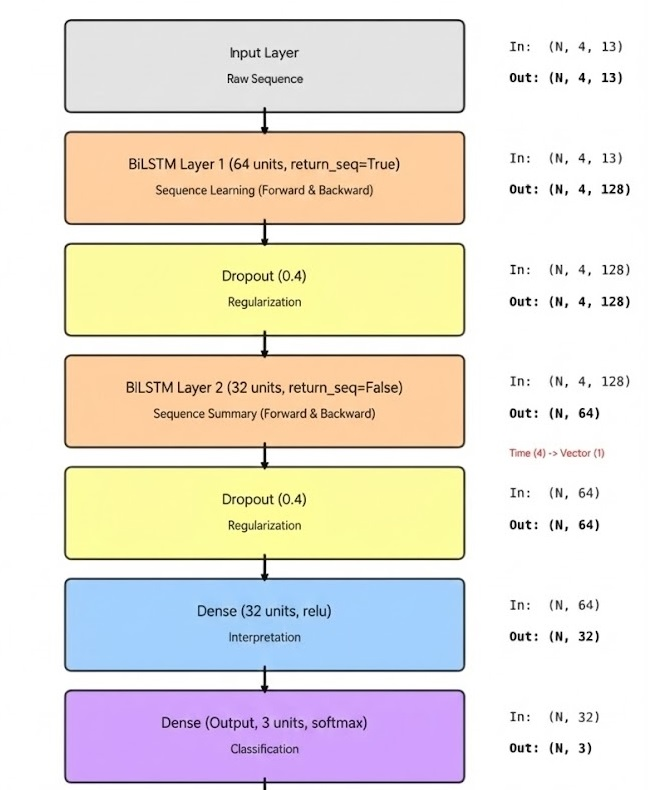

### Compilation
- Optimizer: Adam  
- Loss: sparse categorical cross-entropy  
- Metric: Accuracy  

Usage:
```python
model = build_bilstm_module(input_shape, CONFIG['N_CLASSES'])


In [9]:
# @title BiLSTM Architecture

# --------------------------------------------
# Module: BiLSTM Model Builder
# --------------------------------------------

def build_bilstm_module(input_shape, num_classes):
    """
    Build and compile a Bidirectional LSTM model.

    Architecture:
        Input
        → BiLSTM(64, return_sequences=True)
        → Dropout(0.4)
        → BiLSTM(32, return_sequences=False)
        → Dropout(0.4)
        → Dense(32, relu)
        → Dense(num_classes, softmax)

    Parameters
    ----------
    input_shape : tuple
        The shape of the input sequence (time_steps, num_features).
        Example: (4, 13).

    num_classes : int
        Number of classes to predict (3 in this project).

    Returns
    -------
    tf.keras.Model
        Compiled BiLSTM model ready for training.
    """

    # Start a Sequential model with name for easy identification in logs/saved files
    model = Sequential(name="Bi_LSTM")

    # ---- Input layer ----
    model.add(Input(shape=input_shape))

    # ---- First BiLSTM block ----
    # return_sequences=True keeps the full sequence output for the next BiLSTM layer.
    # 64 units (forward + backward = 128 combined internally)
    model.add(Bidirectional(LSTM(64, return_sequences=True)))

    # ---- Dropout ----
    # High dropout useful when stacking recurrent layers to reduce overfitting.
    model.add(Dropout(0.4))

    # ---- Second BiLSTM block ----
    # return_sequences=False outputs only the final combined representation.
    model.add(Bidirectional(LSTM(32, return_sequences=False)))

    # ---- Dropout ----
    model.add(Dropout(0.4))

    # ---- Dense hidden layer ----
    model.add(Dense(32, activation='relu'))

    # ---- Output classification layer ----
    model.add(Dense(num_classes, activation='softmax'))

    # ---- Compile model ----
    # Sparse categorical crossentropy used because labels are integer-encoded.
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Example usage:
# model = build_bilstm_module((4,13), 3)
# model.summary()


# Module 4: Evaluator — thresholding & metrics

**Purpose:**  
Centralize prediction thresholding and metric computation. This module provides three static utilities:

- `apply_threshold(y_pred_prob, threshold)` — convert soft probabilities to class labels using a priority threshold (class 2 → class 1 → else 0).  
- `tune_threshold(y_true, y_pred_prob)` — grid-search thresholds to maximize macro-F1 (used **on training predictions only**).  
- `get_full_metrics(y_true, y_pred_prob, threshold)` — compute Accuracy, Macro Precision/Recall/F1, Macro ROC-AUC and Macro PR-AUC, and the confusion matrix.

**Important usage note:** Tune thresholds on the **training** predictions (or CV/validation) and then **apply that fixed threshold** to the holdout/test set to avoid data leakage.


In [10]:
# @title Evaluator
# Module: Evaluator

class Evaluator:
    """
    Thresholding and evaluation helpers.
    - apply_threshold: priority thresholding (class 2 > class 1 > class 0)
    - tune_threshold: grid-search thresholds to maximize macro-F1
    - get_full_metrics: compute standard and AUC metrics + confusion matrix
    """

    @staticmethod
    def apply_threshold(y_pred_prob, threshold):
        """
        Convert predicted probabilities (N x C) to discrete class labels using a priority threshold.

        Parameters
        ----------
        y_pred_prob : array-like, shape (N, C)
            Predicted class probabilities for each sample.
        threshold : float
            Probability threshold to decide whether a sample should be assigned to class 2 or 1.
            Priority logic: check class 2 first, then class 1, else class 0.

        Returns
        -------
        np.array of shape (N,)
            Integer class predictions {0,1,2}.
        """
        y_pred = []                          # will collect integer labels
        for probs in y_pred_prob:            # probs is a vector of length C (here C=3)
            if probs[2] >= threshold:        # if class-2 probability passes threshold → class 2
                y_pred.append(2)
            elif probs[1] >= threshold:      # else if class-1 passes threshold → class 1
                y_pred.append(1)
            else:                            # otherwise default to class 0
                y_pred.append(0)
        return np.array(y_pred)              # return as numpy array for downstream sklearn metrics

    @staticmethod
    def tune_threshold(y_true, y_pred_prob):
        """
        Grid-search simple thresholds to maximize macro-F1 on the provided set.

        Parameters
        ----------
        y_true : array-like, shape (N,)
            Ground-truth integer labels.
        y_pred_prob : array-like, shape (N, C)
            Predicted probabilities from the model.

        Returns
        -------
        float
            The threshold (scalar) that achieved the highest macro-F1 on the grid.
        """
        best_thresh = 0.5
        best_f1 = 0.0
        # iterate thresholds from 0.10 up to 0.95 in steps of 0.05
        for t in np.arange(0.1, 0.96, 0.05):
            # apply this candidate threshold to get discrete labels
            y_temp = Evaluator.apply_threshold(y_pred_prob, t)
            # compute macro-F1; zero_division=0 prevents errors if a class has no predicted samples
            score = f1_score(y_true, y_temp, average='macro', zero_division=0)
            # keep the best threshold seen so far
            if score > best_f1:
                best_f1 = score
                best_thresh = t
        return best_thresh

    @staticmethod
    def get_full_metrics(y_true, y_pred_prob, threshold):
        """
        Compute a set of evaluation metrics using the provided threshold.

        Parameters
        ----------
        y_true : array-like, shape (N,)
            Ground-truth integer labels.
        y_pred_prob : array-like, shape (N, C)
            Predicted probabilities from the model.
        threshold : float
            Threshold to convert probabilities to discrete predictions (applied via apply_threshold).

        Returns
        -------
        dict
            Dictionary containing:
            - 'Accuracy'
            - 'Macro Precision'
            - 'Macro Recall'
            - 'Macro F1'
            - 'Macro ROC-AUC' (may be 0.0 on failure)
            - 'Macro PR-AUC'  (may be 0.0 on failure)
            - 'Confusion_Matrix' (numpy array)
        """
        # Convert probabilities -> labels using priority thresholding
        y_pred = Evaluator.apply_threshold(y_pred_prob, threshold)

        # Basic classification metrics (macro-averaged for multiclass)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # Advanced AUC metrics: need binarized labels (one-vs-rest)
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(CONFIG['N_CLASSES'])))
            # Macro ROC-AUC across classes (OVR)
            roc_auc = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr', average='macro')
            # Macro PR-AUC (average precision)
            pr_auc = average_precision_score(y_true_bin, y_pred_prob, average='macro')
        except Exception:
            # If AUC calculations fail (e.g., degenerate class distribution), return safe defaults
            roc_auc = 0.0
            pr_auc = 0.0

        # Confusion matrix (counts)
        cm = confusion_matrix(y_true, y_pred)

        # Return a compact dictionary of metrics
        return {
            'Accuracy': acc,
            'Macro Precision': prec,
            'Macro Recall': rec,
            'Macro F1': f1,
            'Macro ROC-AUC': roc_auc,
            'Macro PR-AUC': pr_auc,
            'Confusion_Matrix': cm
        }

# -------------------------
# Usage example (short)
# -------------------------
# After training a model `model`:
# y_train_proba = model.predict(X_train_3d)
# train_thresh = Evaluator.tune_threshold(y_train, y_train_proba)   # tune on training predictions only
# train_metrics = Evaluator.get_full_metrics(y_train, y_train_proba, train_thresh)
#
# y_test_proba = model.predict(X_test_3d)
# test_metrics = Evaluator.get_full_metrics(y_test, y_test_proba, train_thresh)  # apply train threshold to test
#
# Print / save metrics as needed.

# Module 5 : Plot Utility

This helper module provides a clean visualization of model training progress.

### Purpose
After each model finishes training, this function:
- Plots **training loss** and **validation loss**
- Plots **training accuracy** and **validation accuracy**
- Saves the plot as a PNG file inside the model's output directory
- Displays the plot inside the notebook

### Why this is needed
Training curves help diagnose:
- Overfitting (train ↑, val ↓)
- Underfitting (both low)
- Training stability
- Whether early stopping or LR scheduling behaved correctly

### Usage
Inside a model training cell:
```python
_plot_history(history.history, model_name, save_dir)


In [11]:
# @title Training Visualization (Loss & Accuracy)
# -------------------------------------------------------
# Module: Training Visualization Helper (_plot_history)
# -------------------------------------------------------

def _plot_history(history, model_name, save_dir):
    """
    Plot and save the training curves for loss and accuracy.

    Parameters
    ----------
    history : dict
        Keras model training history (history.history dictionary).
    model_name : str
        Name of the model (e.g., 'LSTM', 'CNN-LSTM', 'BiLSTM').
    save_dir : str
        Directory where the plot image will be saved.

    Saves
    -----
    <model_name>_training_history.png inside save_dir

    Notes
    -----
    - Works for models compiled with 'accuracy' metric.
    - Does not modify training; only visualizes.
    """

    plt.figure(figsize=(10, 4))

    # -----------------------------
    # SUBPLOT 1: Loss curves
    # -----------------------------
    plt.subplot(1, 2, 1)

    # Plot training loss (present in all Keras history dicts)
    plt.plot(history.get('loss', []), label='train_loss')

    # Validation loss is only present when validation_split or val_data is used
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='val_loss')

    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # -----------------------------
    # SUBPLOT 2: Accuracy curves
    # -----------------------------
    plt.subplot(1, 2, 2)

    # Plot train accuracy if available
    if 'accuracy' in history:
        plt.plot(history['accuracy'], label='train_acc')

    # Plot val accuracy only if validation data was provided
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='val_acc')

    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # -----------------------------
    # Finalize figure
    # -----------------------------
    plt.tight_layout()

    # Save the plot to the given directory
    fname = os.path.join(save_dir, f"{model_name}_training_history.png")
    plt.savefig(fname, dpi=200)

    # Show the plot directly in notebook
    plt.show()

    print(f"[Helper] Saved training history -> {fname}")


# Module 6 : Save Model & Metrics Utility

This utility module handles saving the trained model and its evaluation metrics.

### What this module does
1. Creates an output directory if it does not already exist  
2. Saves the trained model in `.h5` format with a timestamped filename  
3. Saves all evaluation metrics (train + test) into a timestamped `.json` file  
4. Ensures JSON compatibility by automatically converting NumPy values into Python floats  


### Usage inside training cells:
```python
_save_metrics_and_model_files(model, metrics_obj, model_name, save_dir)


In [12]:
# @title Save Model & Metrics

# -----------------------------------------------------
# Module: Save Model & Metrics Helper
# -----------------------------------------------------

def _save_metrics_and_model_files(model, metrics_obj, model_name, save_dir):
    """
    Save the trained model (.h5) and its metrics (.json) into the specified directory.

    Parameters
    ----------
    model : tf.keras.Model
        The trained model to be saved.

    metrics_obj : dict
        Dictionary of metrics (train and test), ready to be written to JSON.
        Should contain only JSON-serializable values or NumPy numbers.

    model_name : str
        Name of the model (e.g., 'LSTM', 'CNN-LSTM', 'BiLSTM').

    save_dir : str
        Output directory where the model and metrics files will be saved.

    Returns
    -------
    tuple(str, str)
        (path_to_saved_model_h5, path_to_saved_metrics_json)
    """

    # Ensure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create a timestamp for file names so every run is preserved
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    # -------------------------------
    # Save model file (.h5)
    # -------------------------------
    model_fname = os.path.join(save_dir, f"{model_name}_final_model_{ts}.h5")
    model.save(model_fname)  # standard TensorFlow HDF5 format
    # Note: Saved model can later be loaded via tf.keras.models.load_model()

    # -------------------------------
    # Save metrics JSON file
    # -------------------------------
    metrics_fname = os.path.join(save_dir, f"{model_name}_metrics_{ts}.json")
    with open(metrics_fname, 'w') as f:
        # default lambda converts numpy types (np.float32, np.int64) → Python float/str
        json.dump(
            metrics_obj,
            f,
            indent=2,
            default=lambda x: float(x)
            if isinstance(x, (np.floating, np.integer))
            else str(x)
        )

    # -------------------------------
    # Print confirmation summary
    # -------------------------------
    print(f"[Helper] Saved model -> {model_fname}")
    print(f"[Helper] Saved metrics -> {metrics_fname}")

    return model_fname, metrics_fname


# Module 7 : Define function to run models — train, tune (train-only), evaluate (test)

**Purpose:**  
Train one model (LSTM / CNN-LSTM / BiLSTM) end-to-end, tune the probability threshold on the **training** predictions only, then apply that fixed threshold to the **holdout/test** set. The function saves the trained model (`.h5`), a timestamped metrics JSON (contains train & test metrics and training history), and confusion matrix PNGs.

**Inputs**
- `model_builder`: function that returns a compiled Keras model (e.g., `build_lstm_module`)
- `model_name`: string name used for folders and file prefixes
- `X_train, y_train`: training arrays (flattened) — scaler already applied
- `X_test, y_test`: holdout arrays (flattened/scaled)
- `save_dir_root`: base output folder (default `'outputs'`)

**Outputs**
- Console: training progress, train/test metrics, classification reports
- Files in `outputs/<model_name>/`:
  - `<model_name>_final_model_<timestamp>.h5`
  - `<model_name>_metrics_<timestamp>.json` (contains train & test metrics, thresholds, history)
  - confusion matrix PNGs and training history PNG

**When to run:** after Modules 1–6 (imports/config, DataEngine, DataAnalyzer, model builders, Evaluator) and after preparing `X_train_full`, `y_train_full`, `X_holdout`, `y_holdout` (scaling applied).

**Important:** Threshold tuning is performed **only on training predictions**; the chosen threshold is then applied to test predictions (no tuning on test). This avoids test leakage.


In [13]:
# @title Single model run function
# -----------------------------------------------------
# Module: run_single_model
# -----------------------------------------------------

def run_single_model(model_builder, model_name, X_train, y_train, X_test, y_test, save_dir_root='outputs'):
    """
    Train a model, tune threshold on TRAIN (only), and apply that threshold to TEST.
    Returns a summary dict and saves model + metrics to disk.

    NOTE: Assumes DataEngine 'engine', Evaluator, _plot_history, and
          _save_metrics_and_model_files are already defined and available.
    """

    # Prepare per-model save directory and ensure it exists
    save_dir = os.path.join(save_dir_root, model_name)
    os.makedirs(save_dir, exist_ok=True)

    # Reshape flat inputs into 3D tensors for Keras LSTM: (N, time_steps, features)
    # engine.reshape_for_lstm uses CONFIG['SUFFIXES'] and BASE_FEATURES to compute shape.
    X_train_3d = engine.reshape_for_lstm(X_train)
    X_test_3d  = engine.reshape_for_lstm(X_test)

    # Derive input shape for model builder (time_steps, num_features)
    input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])
    print(f"[{model_name}] Input shape: {input_shape}")

    # Compute class weights from the training labels to handle imbalance (keeps original approach)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = dict(enumerate(weights))
    print(f"[{model_name}] Class weights: {weight_dict}")

    # Build the model using the supplied builder (architecture unchanged)
    model = model_builder(input_shape, CONFIG['N_CLASSES'])

    # Standard callbacks used across experiments: early stop and LR reduction
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    ]

    # -------------------------
    # Train the model
    # -------------------------
    # validation_split=0.1 keeps an internal validation set for early stopping only.
    history = model.fit(
        X_train_3d, y_train,
        epochs=CONFIG['EPOCHS'],
        batch_size=CONFIG['BATCH_SIZE'],
        validation_split=0.1,   # internal val used for callbacks (not for final eval)
        class_weight=weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    # Plot & save training curves (loss / accuracy)
    try:
        _plot_history(history.history, model_name, save_dir)
    except Exception as e:
        print(f"[{model_name}] Warning: history plot failed: {e}")

    # -------------------------
    # A) Threshold tuning on TRAIN set (no test leakage)
    # -------------------------
    # Get predicted probabilities on the full training set
    y_train_proba = model.predict(X_train_3d, verbose=0)

    # Tune threshold using Evaluator.tune_threshold on training predictions only
    best_thresh_train = Evaluator.tune_threshold(y_train, y_train_proba)
    # Compute full metric dictionary using that threshold (training metrics)
    train_metrics = Evaluator.get_full_metrics(y_train, y_train_proba, best_thresh_train)

    # Print training threshold and metrics (concise)
    print(f"\n[{model_name}] TRAIN optimal threshold (used for TEST): {best_thresh_train:.2f}")
    print(f"[{model_name}] TRAIN metrics: {train_metrics}")
    print("Classification report (TRAIN):\n", classification_report(y_train, Evaluator.apply_threshold(y_train_proba, best_thresh_train), zero_division=0))

    # Plot and save training confusion matrix
    try:
        plt.figure(figsize=(5,4))
        sns.heatmap(train_metrics['Confusion_Matrix'], annot=True, fmt='d', cmap='Greens')
        plt.title(f"{model_name} Confusion Matrix (Train)")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        fname_train_cm = os.path.join(save_dir, f"{model_name}_confusion_train_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(fname_train_cm, dpi=200)
        plt.show()
        print(f"[{model_name}] Saved train confusion -> {fname_train_cm}")
    except Exception as e:
        print(f"[{model_name}] Warning: train CM plot failed: {e}")

    # -------------------------
    # B) Apply training threshold to TEST set (no tuning on test)
    # -------------------------
    y_test_proba = model.predict(X_test_3d, verbose=0)

    # Apply the threshold found on training to compute test metrics
    test_metrics = Evaluator.get_full_metrics(y_test, y_test_proba, best_thresh_train)
    print(f"\n[{model_name}] TEST metrics (threshold from TRAIN applied): {test_metrics}")
    print("Classification report (TEST):\n", classification_report(y_test, Evaluator.apply_threshold(y_test_proba, best_thresh_train), zero_division=0))

    # Plot and save test confusion matrix
    try:
        plt.figure(figsize=(5,4))
        sns.heatmap(test_metrics['Confusion_Matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f"{model_name} Confusion Matrix (Test)")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        fname_test_cm = os.path.join(save_dir, f"{model_name}_confusion_test_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(fname_test_cm, dpi=200)
        plt.show()
        print(f"[{model_name}] Saved test confusion -> {fname_test_cm}")
    except Exception as e:
        print(f"[{model_name}] Warning: test CM plot failed: {e}")

    # -------------------------
    # Save model and metrics JSON (includes train & test metrics and history)
    # -------------------------
    model_fname, metrics_fname = _save_metrics_and_model_files(model, {
        'model': model_name,
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
        'train_threshold': float(best_thresh_train),
        'train_metrics': train_metrics,
        'test_threshold_applied': float(best_thresh_train),
        'test_metrics': test_metrics,
        'history': history.history
    }, model_name, save_dir)

    # Return a concise summary dict
    return {
        'model': model_name,
        'model_file': model_fname,
        'metrics_file': metrics_fname,
        'train_threshold': float(best_thresh_train),
        'test_threshold_applied': float(best_thresh_train),
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }


# 7.1: Run - LSTM Model (Module Execution)

This cell trains the **LSTM model** using the shared `run_single_model()` pipeline.

### What happens in this cell:
1. The LSTM architecture is built using `build_lstm_module()`
2. Training is performed on the prepared training dataset  
3. Threshold tuning occurs **only on training predictions**
4. The trained model is evaluated on the holdout/test set  
5. All artifacts are saved into:


> outputs/LSTM/
> *   LSTM_final_model_<timestamp>.h5
>*   LSTM_metrics_<timestamp>.json
>*   LSTM_training_history.png
>*   LSTM_confusion_train_.png
>*   LSTM_confusion_test_.png



[LSTM] Input shape: (4, 13)
[LSTM] Class weights: {0: np.float64(0.3476196670135276), 1: np.float64(10.908163265306122), 2: np.float64(31.62721893491124)}
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5546 - loss: 0.9681 - val_accuracy: 0.5493 - val_loss: 0.9078 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5416 - loss: 0.8464 - val_accuracy: 0.5418 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5422 - loss: 0.8256 - val_accuracy: 0.5468 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5332 - loss: 0.8262 - val_accuracy: 0.5549 - val_loss: 0.8447 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5411 - loss: 0.7952 - val_accuracy: 0.5486 - val_loss: 0.8336 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5428 - loss: 0.

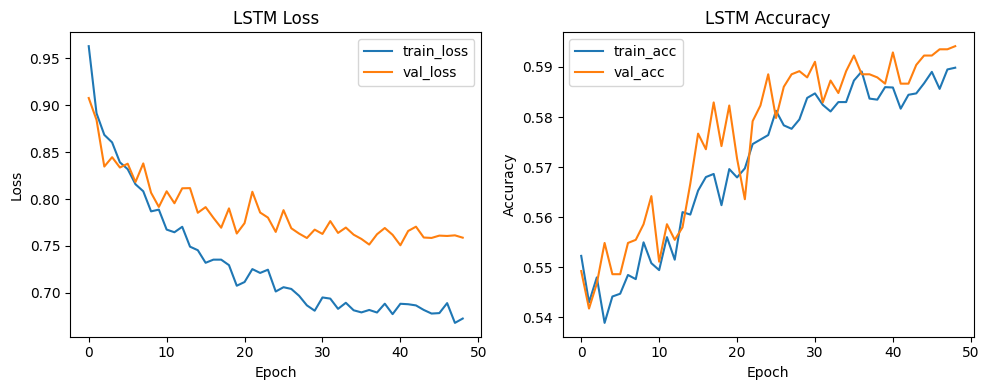

[Helper] Saved training history -> outputs/LSTM/LSTM_training_history.png

[LSTM] TRAIN optimal threshold (used for TEST): 0.85
[LSTM] TRAIN metrics: {'Accuracy': 0.9502338634237605, 'Macro Precision': 0.5108332407815852, 'Macro Recall': 0.4451793710914533, 'Macro F1': 0.4618552915663292, 'Macro ROC-AUC': np.float64(0.828738098050839), 'Macro PR-AUC': np.float64(0.4353497174943593), 'Confusion_Matrix': array([[15145,   118,   113],
       [  440,    50,     0],
       [  127,     0,    42]])}
Classification report (TRAIN):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     15376
           1       0.30      0.10      0.15       490
           2       0.27      0.25      0.26       169

    accuracy                           0.95     16035
   macro avg       0.51      0.45      0.46     16035
weighted avg       0.94      0.95      0.94     16035



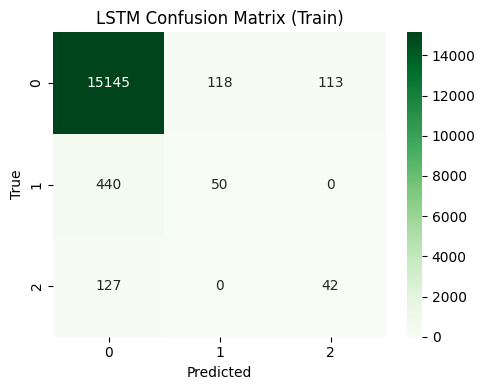

[LSTM] Saved train confusion -> outputs/LSTM/LSTM_confusion_train_20251205_121121.png

[LSTM] TEST metrics (threshold from TRAIN applied): {'Accuracy': 0.9486156148665502, 'Macro Precision': 0.46870073382528904, 'Macro Recall': 0.405733195878116, 'Macro F1': 0.4222827919202308, 'Macro ROC-AUC': np.float64(0.7849243287300874), 'Macro PR-AUC': np.float64(0.40302956537909296), 'Confusion_Matrix': array([[3786,   31,   27],
       [ 112,   11,    0],
       [  36,    0,    6]])}
Classification report (TEST):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      3844
           1       0.26      0.09      0.13       123
           2       0.18      0.14      0.16        42

    accuracy                           0.95      4009
   macro avg       0.47      0.41      0.42      4009
weighted avg       0.93      0.95      0.94      4009



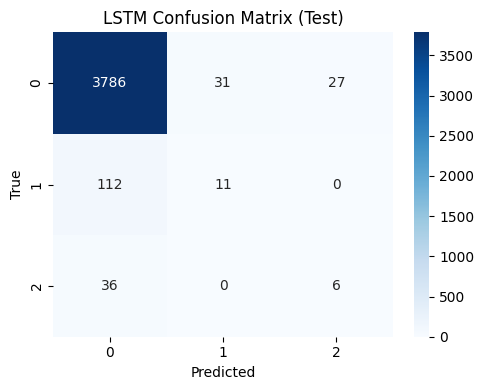

[LSTM] Saved test confusion -> outputs/LSTM/LSTM_confusion_test_20251205_121122.png
[Helper] Saved model -> outputs/LSTM/LSTM_final_model_20251205_121122.h5
[Helper] Saved metrics -> outputs/LSTM/LSTM_metrics_20251205_121122.json

LSTM run summary (train & test):
Train Macro F1: 0.4618552915663292
Test Macro F1 : 0.4222827919202308


In [14]:
# @title Run LSTM model
# -------------------------------------------------------------
# RUN LSTM MODEL (using the unified training + evaluation module)
# -------------------------------------------------------------

# Run the LSTM using run_single_model()
# - build_lstm_module : function that returns the LSTM model
# - 'LSTM'            : name used for folder and file naming
# - X_train_full      : scaled training features
# - y_train_full      : training labels
# - X_holdout         : scaled holdout/test features
# - y_holdout         : test labels
# - save_dir_root     : base directory for outputs (CONFIG['OUTPUT_DIR'])

lstm_summary = run_single_model(
    build_lstm_module,     # model builder
    'LSTM',                # model name
    X_train_full,          # training features
    y_train_full,          # training labels
    X_holdout,             # test features
    y_holdout,             # test labels
    save_dir_root=CONFIG['OUTPUT_DIR']
)

# -------------------------
# Print concise summary
# -------------------------
print("\nLSTM run summary (train & test):")
print("Train Macro F1:", lstm_summary['train_metrics']['Macro F1'])
print("Test Macro F1 :", lstm_summary['test_metrics']['Macro F1'])


# 7.2: Run CNN-LSTM Model (Module Execution)

This cell executes the **CNN–LSTM hybrid model** using the shared `run_single_model()` pipeline.

### What this execution cell does
1. Builds the CNN–LSTM model using `build_cnn_lstm_module()`
2. Trains on the processed training dataset (`X_train_full`, `y_train_full`)
3. Tunes the probability threshold **only** using training predictions  
4. Applies that same threshold to the holdout/test set (`X_holdout`, `y_holdout`)




[CNN-LSTM] Input shape: (4, 13)
[CNN-LSTM] Class weights: {0: np.float64(0.3476196670135276), 1: np.float64(10.908163265306122), 2: np.float64(31.62721893491124)}
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5924 - loss: 0.9889 - val_accuracy: 0.5411 - val_loss: 0.9136 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5385 - loss: 0.8821 - val_accuracy: 0.5337 - val_loss: 0.9245 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5390 - loss: 0.8485 - val_accuracy: 0.5561 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5420 - loss: 0.8172 - val_accuracy: 0.5505 - val_loss: 0.8533 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5446 - loss: 0.8188 - val_accuracy: 0.5430 - val_loss: 0.8809 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5405 - loss

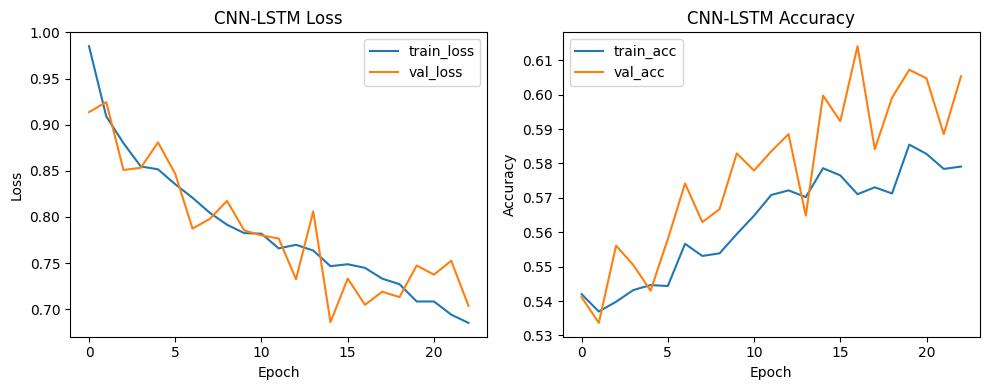

[Helper] Saved training history -> outputs/CNN-LSTM/CNN-LSTM_training_history.png

[CNN-LSTM] TRAIN optimal threshold (used for TEST): 0.65
[CNN-LSTM] TRAIN metrics: {'Accuracy': 0.8969753663860306, 'Macro Precision': 0.4085530504518166, 'Macro Recall': 0.50595430563041, 'Macro F1': 0.4311519362929277, 'Macro ROC-AUC': np.float64(0.8161960200615365), 'Macro PR-AUC': np.float64(0.41179206066075563), 'Confusion_Matrix': array([[14202,   647,   527],
       [  366,   123,     1],
       [  107,     4,    58]])}
Classification report (TRAIN):
               precision    recall  f1-score   support

           0       0.97      0.92      0.95     15376
           1       0.16      0.25      0.19       490
           2       0.10      0.34      0.15       169

    accuracy                           0.90     16035
   macro avg       0.41      0.51      0.43     16035
weighted avg       0.93      0.90      0.91     16035



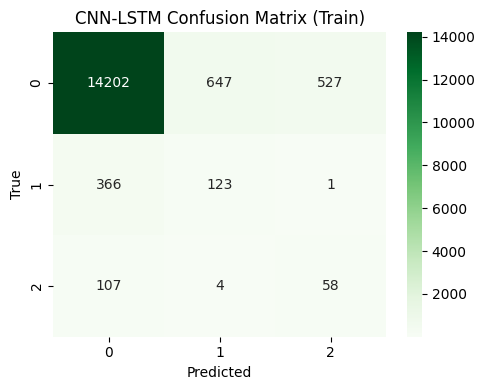

[CNN-LSTM] Saved train confusion -> outputs/CNN-LSTM/CNN-LSTM_confusion_train_20251205_121229.png

[CNN-LSTM] TEST metrics (threshold from TRAIN applied): {'Accuracy': 0.9019705662259915, 'Macro Precision': 0.40026295933948064, 'Macro Recall': 0.4759457398349812, 'Macro F1': 0.4182881726186433, 'Macro ROC-AUC': np.float64(0.7912014379678286), 'Macro PR-AUC': np.float64(0.3911296722006366), 'Confusion_Matrix': array([[3580,  143,  121],
       [ 100,   23,    0],
       [  29,    0,   13]])}
Classification report (TEST):
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      3844
           1       0.14      0.19      0.16       123
           2       0.10      0.31      0.15        42

    accuracy                           0.90      4009
   macro avg       0.40      0.48      0.42      4009
weighted avg       0.93      0.90      0.92      4009



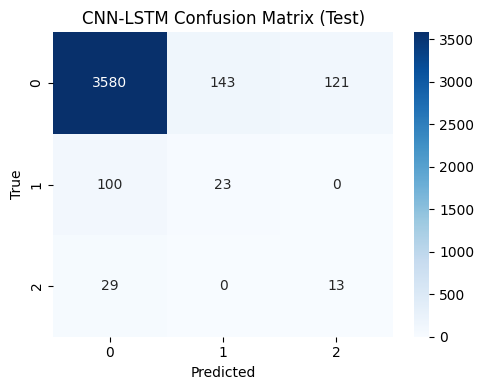

[CNN-LSTM] Saved test confusion -> outputs/CNN-LSTM/CNN-LSTM_confusion_test_20251205_121230.png
[Helper] Saved model -> outputs/CNN-LSTM/CNN-LSTM_final_model_20251205_121230.h5
[Helper] Saved metrics -> outputs/CNN-LSTM/CNN-LSTM_metrics_20251205_121230.json

CNN-LSTM run summary (train & test):
Train Macro F1: 0.4311519362929277
Test Macro F1 : 0.4182881726186433


In [15]:
# @title Run CNN–LSTM model
# -------------------------------------------------------------
# RUN CNN–LSTM MODEL (using shared training/evaluation pipeline)
# -------------------------------------------------------------

# run_single_model():
# - trains the model
# - tunes threshold on training only
# - applies threshold to test
# - saves .h5 model, metrics JSON, confusion matrices, and training plots

cnn_lstm_summary = run_single_model(
    build_cnn_lstm_module,   # CNN–LSTM architecture builder
    'CNN-LSTM',              # folder name / prefix for outputs
    X_train_full,            # scaled training features
    y_train_full,            # training labels
    X_holdout,               # scaled holdout/test features
    y_holdout,               # test labels
    save_dir_root=CONFIG['OUTPUT_DIR']
)

# -------------------------
# Print concise summary of performance
# -------------------------
print("\nCNN-LSTM run summary (train & test):")
print("Train Macro F1:", cnn_lstm_summary['train_metrics']['Macro F1'])
print("Test Macro F1 :", cnn_lstm_summary['test_metrics']['Macro F1'])


# 7.3: Run BiLSTM Model (Module Execution)



 Bi-LSTM Model (Module Execution)

This cell executes the **Bidirectional LSTM (BiLSTM)** model using the unified `run_single_model()` training pipeline.

### What this execution performs
1. Builds the BiLSTM architecture using `build_bilstm_module()`  
2. Trains on the full training dataset (`X_train_full`, `y_train_full`)  
3. Tunes the prediction threshold on **training predictions only**  
4. Applies the same threshold to the **holdout/test set**




[Bi-LSTM] Input shape: (4, 13)
[Bi-LSTM] Class weights: {0: np.float64(0.3476196670135276), 1: np.float64(10.908163265306122), 2: np.float64(31.62721893491124)}
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5180 - loss: 0.9727 - val_accuracy: 0.5436 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5355 - loss: 0.8647 - val_accuracy: 0.5542 - val_loss: 0.8381 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5447 - loss: 0.8307 - val_accuracy: 0.5430 - val_loss: 0.8698 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5329 - loss: 0.8174 - val_accuracy: 0.5561 - val_loss: 0.8280 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5442 - loss: 0.8012 - val_accuracy: 0.5680 - val_loss: 0.7654 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5545 -

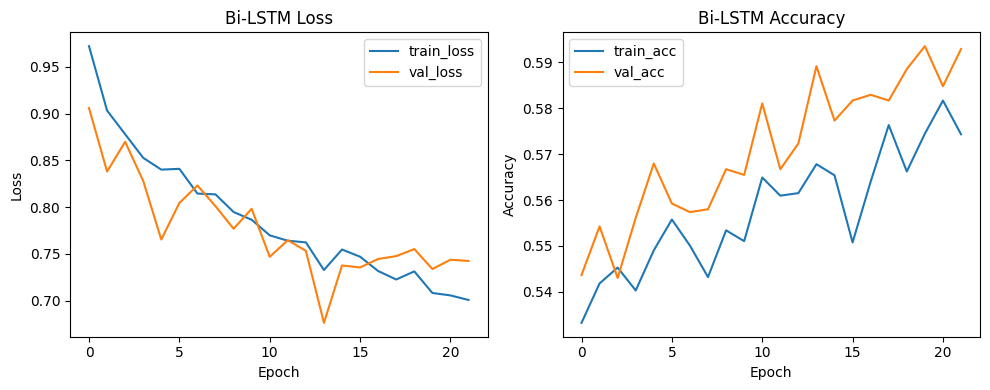

[Helper] Saved training history -> outputs/Bi-LSTM/Bi-LSTM_training_history.png

[Bi-LSTM] TRAIN optimal threshold (used for TEST): 0.65
[Bi-LSTM] TRAIN metrics: {'Accuracy': 0.8959151855316495, 'Macro Precision': 0.4009066697704695, 'Macro Recall': 0.49038797571747456, 'Macro F1': 0.4169337078127618, 'Macro ROC-AUC': np.float64(0.8139822174347513), 'Macro PR-AUC': np.float64(0.40067973570800897), 'Confusion_Matrix': array([[14212,   525,   639],
       [  384,    94,    12],
       [  109,     0,    60]])}
Classification report (TRAIN):
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     15376
           1       0.15      0.19      0.17       490
           2       0.08      0.36      0.14       169

    accuracy                           0.90     16035
   macro avg       0.40      0.49      0.42     16035
weighted avg       0.93      0.90      0.91     16035



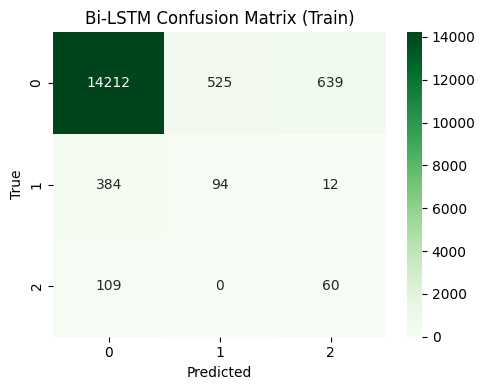

[Bi-LSTM] Saved train confusion -> outputs/Bi-LSTM/Bi-LSTM_confusion_train_20251205_121505.png

[Bi-LSTM] TEST metrics (threshold from TRAIN applied): {'Accuracy': 0.8937390870541282, 'Macro Precision': 0.3857554333595182, 'Macro Recall': 0.462570746935357, 'Macro F1': 0.39634017128492305, 'Macro ROC-AUC': np.float64(0.7765554767416584), 'Macro PR-AUC': np.float64(0.3818087443420463), 'Confusion_Matrix': array([[3553,  118,  173],
       [ 104,   16,    3],
       [  28,    0,   14]])}
Classification report (TEST):
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3844
           1       0.12      0.13      0.12       123
           2       0.07      0.33      0.12        42

    accuracy                           0.89      4009
   macro avg       0.39      0.46      0.40      4009
weighted avg       0.93      0.89      0.91      4009



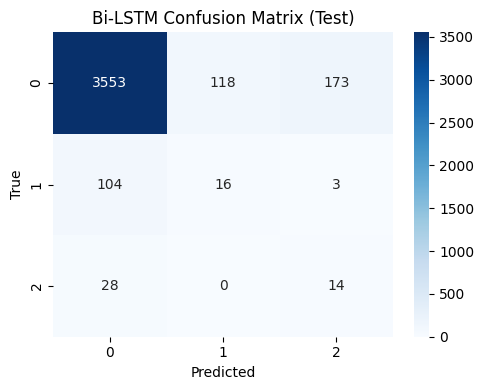

[Bi-LSTM] Saved test confusion -> outputs/Bi-LSTM/Bi-LSTM_confusion_test_20251205_121506.png
[Helper] Saved model -> outputs/Bi-LSTM/Bi-LSTM_final_model_20251205_121506.h5
[Helper] Saved metrics -> outputs/Bi-LSTM/Bi-LSTM_metrics_20251205_121506.json

Bi-LSTM run summary (train & test):
Train Macro F1: 0.4169337078127618
Test Macro F1 : 0.39634017128492305


In [16]:
# @title Run Bi-LSTM model
# -------------------------------------------------------------
# RUN Bi-LSTM MODEL (using shared training/evaluation pipeline)
# -------------------------------------------------------------

# run_single_model():
# - trains BiLSTM model
# - tunes threshold on training only (correct, no test leakage)
# - applies threshold to test
# - saves model (.h5), metrics (.json), and all figures (history + confusions)

bilstm_summary = run_single_model(
    build_bilstm_module,     # Bi-LSTM architecture builder
    'Bi-LSTM',               # folder name and prefix for all output files
    X_train_full,            # scaled training features
    y_train_full,            # training labels
    X_holdout,               # scaled holdout/test features
    y_holdout,               # test labels
    save_dir_root=CONFIG['OUTPUT_DIR']
)

# -------------------------
# Short result summary
# -------------------------
print("\nBi-LSTM run summary (train & test):")
print("Train Macro F1:", bilstm_summary['train_metrics']['Macro F1'])
print("Test Macro F1 :", bilstm_summary['test_metrics']['Macro F1'])


# Module 8: Final Comparison

**Purpose:**  
Collect the latest metrics JSON from each model folder under `outputs/`, build a compact summary table (one row per model), save it as `outputs/comparison_summary.csv`, and plot two grouped bar charts:

- **Top chart:** Train metrics across models  
- **Bottom chart:** Test metrics across models (threshold tuned on training and applied to test)

**Expected outputs:**
- A pandas `DataFrame` displayed inline with train/test metrics.
- `outputs/comparison_summary.csv` saved to disk.
- Two plotted bar charts (Train and Test).
- Console message confirming CSV save.

**Run order:** Execute after running the per-model training cells (LSTM, CNN-LSTM, Bi-LSTM) so metrics JSON files are available.


,train_Accuracy,train_Macro F1,train_Macro Precision,train_Macro Recall,train_Macro ROC-AUC,train_Macro PR-AUC,test_Accuracy,test_Macro F1,test_Macro Precision,test_Macro Recall,test_Macro ROC-AUC,test_Macro PR-AUC
model,,,,,,,,,,,,
Bi-LSTM,0.895915,0.416934,0.400907,0.490388,0.813982,0.400680,0.893739,0.396340,0.385755,0.462571,0.776555,0.381809
CNN-LSTM,0.896975,0.431152,0.408553,0.505954,0.816196,0.411792,0.901971,0.418288,0.400263,0.475946,0.791201,0.391130
LSTM,0.950234,0.461855,0.510833,0.445179,0.828738,0.435350,0.948616,0.422283,0.468701,0.405733,0.784924,0.403030


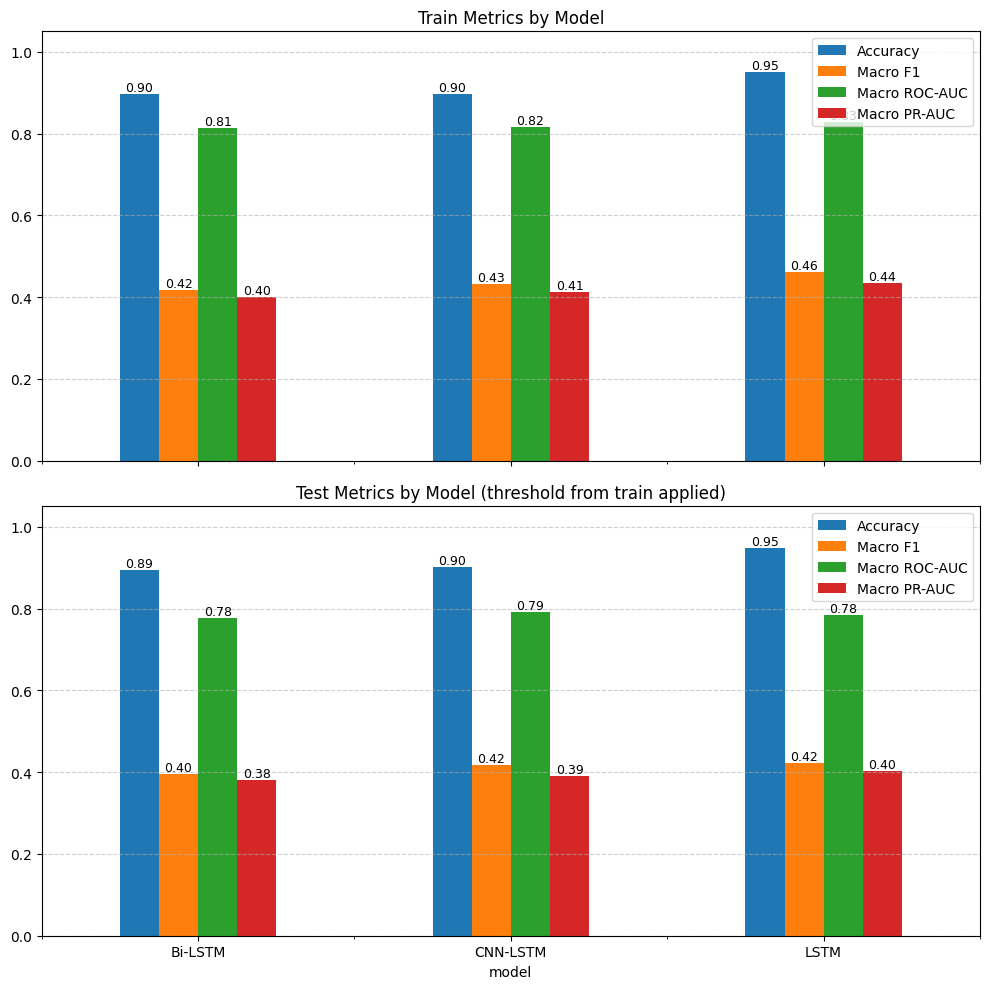

Saved summary CSV -> outputs/comparison_summary.csv


In [17]:
# @title Final Comparison
# -----------------------------------------------------------
# Module: Final Comparison — collect metrics, show table, plot
# -----------------------------------------------------------

import glob
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTPUT_ROOT = 'outputs'
SUMMARY_CSV = os.path.join(OUTPUT_ROOT, 'comparison_summary.csv')

def _find_latest_metrics_json(model_dir):
    """
    Return the most recent metrics JSON file in model_dir, or None if none exist.
    """
    files = sorted(glob.glob(os.path.join(model_dir, '*_metrics_*.json')))
    return files[-1] if files else None

# Collect metrics compactly from each model folder
rows = []
# List model directories under OUTPUT_ROOT (sorted for reproducible ordering)
for model_name in sorted([d for d in os.listdir(OUTPUT_ROOT) if os.path.isdir(os.path.join(OUTPUT_ROOT, d))]):
    metrics_file = _find_latest_metrics_json(os.path.join(OUTPUT_ROOT, model_name))
    if not metrics_file:
        # skip folders without metrics JSON
        continue

    # Load the metrics JSON (expected structure contains 'train_metrics' and 'test_metrics')
    with open(metrics_file, 'r') as f:
        m = json.load(f)

    train_m = m.get('train_metrics', {})
    test_m  = m.get('test_metrics', {})

    # Append a compact row with desired metrics (use NaN if a metric is missing)
    rows.append({
        'model': model_name,
        'train_Accuracy': train_m.get('Accuracy', np.nan),
        'train_Macro F1': train_m.get('Macro F1', np.nan),
        'train_Macro Precision': train_m.get('Macro Precision', np.nan),
        'train_Macro Recall': train_m.get('Macro Recall', np.nan),
        'train_Macro ROC-AUC': train_m.get('Macro ROC-AUC', np.nan),
        'train_Macro PR-AUC': train_m.get('Macro PR-AUC', np.nan),
        'test_Accuracy': test_m.get('Accuracy', np.nan),
        'test_Macro F1': test_m.get('Macro F1', np.nan),
        'test_Macro Precision': test_m.get('Macro Precision', np.nan),
        'test_Macro Recall': test_m.get('Macro Recall', np.nan),
        'test_Macro ROC-AUC': test_m.get('Macro ROC-AUC', np.nan),
        'test_Macro PR-AUC': test_m.get('Macro PR-AUC', np.nan),
    })

# If no model metrics were found, inform the user
if not rows:
    print("No metrics found in outputs/. Run model cells first.")
else:
    # Build DataFrame, set model as index and sort
    df = pd.DataFrame(rows).set_index('model').sort_index()

    # If you want the table sorted by a specific metric (e.g., test_Macro F1 descending)
    # df = df.sort_values(by='test_Macro F1', ascending=False)


    # Save a single CSV summary for easy export / sharing
    df.to_csv(SUMMARY_CSV)
    display(df)  # show the compact table in the notebook

    # Metrics we will plot for both train and test (kept short and informative)
    metrics = ['Accuracy','Macro F1','Macro ROC-AUC','Macro PR-AUC']

    # Build per-split DataFrames that have identical column order
    train_df = df[[f"train_{m}" for m in metrics]].rename(columns=lambda c: c.replace('train_',''))
    test_df  = df[[f"test_{m}"  for m in metrics]].rename(columns=lambda c: c.replace('test_',''))

    # Create two stacked bar charts (Train on top, Test below)
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Top: Train metrics
    train_df.plot(kind='bar', ax=axes[0], rot=0)
    axes[0].set_title('Train Metrics by Model')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)
    # Annotate values on bars for readability
    for p in axes[0].patches:
        h = p.get_height()
        if not np.isnan(h):
            axes[0].annotate(f"{h:.2f}", (p.get_x() + p.get_width()/2., h), ha='center', va='bottom', fontsize=9)

    # Bottom: Test metrics (note: thresholds were tuned on training and applied to test)
    test_df.plot(kind='bar', ax=axes[1], rot=0)
    axes[1].set_title('Test Metrics by Model (threshold from train applied)')
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)
    for p in axes[1].patches:
        h = p.get_height()
        if not np.isnan(h):
            axes[1].annotate(f"{h:.2f}", (p.get_x() + p.get_width()/2., h), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"Saved summary CSV -> {SUMMARY_CSV}")
